In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import folium
from pyspark.sql import SparkSession, Window, functions as F
from pyspark.sql.functions import countDistinct, col, date_format
import numpy as np
import pyspark.sql.functions as func
from pyspark.sql.types import (
    StringType,
    LongType,
    DoubleType,
    StructField,
    StructType,
    FloatType,
    BooleanType
)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Start Spark Session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2 BNPL")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.executor.memory", "8g")
    .getOrCreate()
)

22/10/01 02:58:25 WARN Utils: Your hostname, LAPTOP-URHBN55Q resolves to a loopback address: 127.0.1.1; using 192.168.0.108 instead (on interface wifi0)
22/10/01 02:58:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/01 02:58:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# load all transactions datasets
paths=['../data/tables/transactions_20210228_20210827_snapshot',
       '../data/tables/transactions_20210828_20220227_snapshot',
       '../data/tables/transactions_20220228_20220828_snapshot']

first = 1
for path in paths:
    if first:
        transactions = spark.read.parquet(path)
        print(f'added {path.split("/")[3]}')
        first = 0
    else:
        append_transactions = spark.read.parquet(path)
        transactions = transactions.union(append_transactions)
        print(f'added {path.split("/")[3]}')

added transactions_20210228_20210827_snapshot
added transactions_20210828_20220227_snapshot
added transactions_20220228_20220828_snapshot


In [4]:
consumer = spark.read.csv("../data/tables/tbl_consumer.csv", header=True, sep="|")
details = spark.read.parquet("../data/tables/consumer_user_details.parquet")
merchants = spark.read.parquet("../data/tables/tbl_merchants.parquet")

In [5]:
# rename columns
merchants = merchants.withColumnRenamed('name', 'merchant_name')
consumer = consumer.withColumnRenamed('name', 'consumer_name')

In [6]:
# Join consumers with their respective details
consumer_detail = consumer.join(details, on="consumer_id")

# Join consumers with their respective transactions
consumer_trx = consumer_detail.join(transactions, on="user_id")

# Join transactions with the respective merchants
df_trx = consumer_trx.join(merchants, on="merchant_abn")

In [7]:
@F.udf(StringType())
def normalize_tags(col):
    return col.replace("(", "[").replace(")", "]")[1:-1]

@F.udf(StringType())
def clean_string(col):
    col = col.lower()
    return " ".join(col.split())

In [8]:
df_trx = df_trx.withColumn("tags", normalize_tags(F.col("tags")))
df_trx = df_trx.withColumn("categories", F.regexp_extract("tags", "(?<=\[)(.*?)(?=\])", 1))
df_trx = df_trx.withColumn("revenue_level", F.regexp_extract("tags", "(?<=,\s\[)([a-e]+?)(?=\],)", 1))
df_trx = df_trx.withColumn("take_rate", F.regexp_extract("tags", "(?<=\[take rate: )(.*?)(?=\])", 1))
df_trx = df_trx.withColumn("take_rate", F.col("take_rate").astype(FloatType()))
df_trx = df_trx.withColumn("categories", clean_string(F.col("categories")))
df_trx = df_trx.where(F.col("dollar_value") >= 35)

In [9]:
fraud_data_consumer = spark.read.csv("../data/tables/consumer_fraud_probability.csv", header=True)
fraud_data_merchant = spark.read.csv("../data/tables/merchant_fraud_probability.csv", header=True)

In [10]:
fraud_trx = df_trx.join(fraud_data_merchant, on=["merchant_abn", "order_datetime"], how="left").withColumnRenamed("fraud_probability", "fraud_merchant_pr")
fraud_trx = fraud_trx.join(fraud_data_consumer, on=["user_id", "order_datetime"], how="left").withColumnRenamed("fraud_probability", "fraud_consumer_pr")
fraud_trx = fraud_trx.where((F.col("fraud_merchant_pr").isNotNull()) | F.col("fraud_consumer_pr").isNotNull())
fraud_trx = fraud_trx.distinct()

In [11]:
fraud_trx.groupby("categories").agg({"dollar_value": "mean"})

categories,avg(dollar_value)
"opticians, optica...",180.11318595992938
"watch, clock, and...",113.32377663496496
computer programm...,306.83988016031
digital goods: bo...,92.20923697156981
"books, periodical...",370.7721529589492
florists supplies...,228.00031699696774
art dealers and g...,4134.239411454479
antique shops - s...,8990.350406350399
"gift, card, novel...",96.3113220282952
"equipment, tool, ...",3874.0518151882416


In [12]:
fraud_trx.groupby("categories").agg(F.percentile_approx("dollar_value", 0.5).alias("median"))

categories,median
"opticians, optica...",106.30811865982163
"watch, clock, and...",88.74585943337901
computer programm...,198.2068452981697
digital goods: bo...,79.11310751108492
"books, periodical...",284.4484332983803
florists supplies...,120.83186219009423
art dealers and g...,3511.2837845131344
antique shops - s...,6600.867064638659
"gift, card, novel...",83.20861964063579
"equipment, tool, ...",3544.4178736935846


In [13]:
fraud_trx.groupby("categories").agg({"dollar_value": "stddev"})

categories,stddev(dollar_value)
"opticians, optica...",190.11863341812776
"watch, clock, and...",80.40078862317861
computer programm...,700.9056756278819
digital goods: bo...,50.341898237901376
"books, periodical...",324.6634273126157
florists supplies...,250.10515484425542
art dealers and g...,3132.126743420788
antique shops - s...,9325.983913863543
"gift, card, novel...",52.61560155123332
"equipment, tool, ...",1773.4699154320263


In [14]:
@F.udf(FloatType())
def get_mean(col1, col2):
    if col1 and col2:
        return (col1 + col2)/2
    elif not col2:
        return col1
    else:
        return col2

In [11]:
fraud_trx = fraud_trx.withColumn("fraud_merchant_pr", F.col("fraud_merchant_pr").astype(FloatType()))
fraud_trx = fraud_trx.withColumn("fraud_consumer_pr", F.col("fraud_consumer_pr").astype(FloatType()))

In [16]:
fraud_trx = fraud_trx.withColumn("fraud_mean", get_mean(F.col("fraud_merchant_pr"), F.col("fraud_consumer_pr")))

In [17]:
pd_fraud = fraud_trx.toPandas()

In [18]:
pd_fraud[["fraud_merchant_pr", "fraud_consumer_pr"]].describe()

,fraud_merchant_pr,fraud_consumer_pr
count,3612.000000,58661.000000
mean,30.275728,14.486104
std,5.455806,8.804473
min,18.210892,8.287144
25%,28.504478,9.534845
50%,29.102419,11.506072
75%,30.024292,15.668378
max,91.096069,97.629807


In [19]:
pd_fraud

,user_id,order_datetime,merchant_abn,consumer_id,consumer_name,address,state,postcode,gender,dollar_value,order_id,merchant_name,tags,categories,revenue_level,take_rate,fraud_merchant_pr,fraud_consumer_pr,fraud_mean
0,724,2021-09-15,49212265466,1344843,Amy Hogan,19623 Sandoval Tunnel,QLD,4857,Female,328.571527,ff4a0c61-67fd-42dc-96da-cd2d05ee888d,Auctor Company,"[florists supplies, nursery stocK, and flowers...","florists supplies, nursery stock, and flowers",b,4.50,NaN,9.722903,9.722903
1,1936,2021-09-25,97603729191,95690,Mr. David Lopez MD,10039 Guzman Extensions Suite 399,TAS,7263,Undisclosed,1686.440177,2bca9dc9-5f59-4475-b713-0e8c5520143b,Eu Company,"[stAtionery, office supplies and printing and ...","stationery, office supplies and printing and w...",a,6.78,NaN,16.446285,16.446285
2,2007,2022-02-27,13839274306,1231913,Brittney Hooper,229 Cooley Villages,WA,6569,Female,59.253038,084b5c1f-8151-4b59-94cb-8f9a93680e2b,Sit Amet Consectetuer PC,"[computErs, computer peripheral equipment, and...","computers, computer peripheral equipment, and ...",a,6.00,NaN,12.239517,12.239517
3,3845,2021-11-28,28748147493,357114,Keith Padilla,732 Davis Port,NSW,1296,Male,122.557294,c0e12e26-2b84-4289-9749-826e0147e560,Neque Institute,"[gift, caRd, novelty, and souvenir shops], [c]...","gift, card, novelty, and souvenir shops",c,2.51,NaN,18.627390,18.627390
4,6734,2021-11-25,66667026714,1285829,Melissa Mckinney,4584 Anthony Summit,VIC,3911,Female,166.733745,f529e1bb-432d-473e-912c-ed9bb4cdb5ba,Sit Amet Risus Foundation,"[digItal goods: books, moviEs, music], [c], [t...","digital goods: books, movies, music",c,1.85,NaN,9.546015,9.546015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61914,16501,2021-12-07,16570599421,1430152,Matthew Stephens,324 Stephens Squares,WA,6847,Male,130.394497,d2c31101-7ab6-411f-907b-dc16a8b77dd4,Non Magna Nam PC,"[digital goods: books, movies, music], [a], [t...","digital goods: books, movies, music",a,6.74,NaN,16.746586,16.746586
61915,19256,2021-05-18,32361057556,855885,William Rivera,4598 Anthony Dale,QLD,4511,Male,61.896095,64fa1f28-42fd-4991-8eb4-2f9ef8e5ce44,Orci In Consequat Corporation,"[gift, card, novelty, and souvenir shops], [a]...","gift, card, novelty, and souvenir shops",a,6.61,NaN,10.681720,10.681720
61916,19597,2021-12-27,93558142492,525572,Michael Bradley,750 Nicole Mountains Apt. 616,WA,6041,Male,334.951713,079ba289-e0ca-4058-8eae-b66eda799435,Dolor Quisque Inc.,"[shoe shops], [b], [take rate: 3.41]",shoe shops,b,3.41,NaN,15.304589,15.304589
61917,20016,2021-11-01,59274084898,748035,James Rowe,07208 Richard Mews,NSW,1515,Male,3166.684386,3a22381f-7614-4b77-98d9-12df5965ef8e,Sodales Elit PC,"[telecom], [c], [take rate: 2.01]",telecom,c,2.01,NaN,14.125520,14.125520


<AxesSubplot:xlabel='dollar_value', ylabel='fraud_mean'>

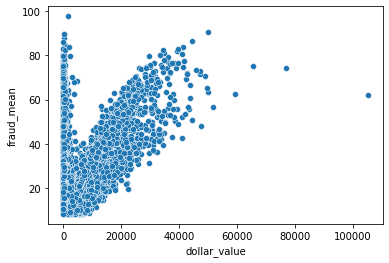

In [20]:
sns.scatterplot(pd_fraud["dollar_value"], pd_fraud["fraud_mean"])

In [21]:
pd_fraud_below_10k = pd_fraud[pd_fraud["dollar_value"] < 10000]

<AxesSubplot:xlabel='dollar_value', ylabel='fraud_mean'>

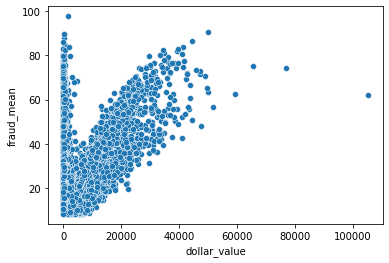

In [22]:
sns.scatterplot(pd_fraud["dollar_value"], pd_fraud["fraud_mean"])

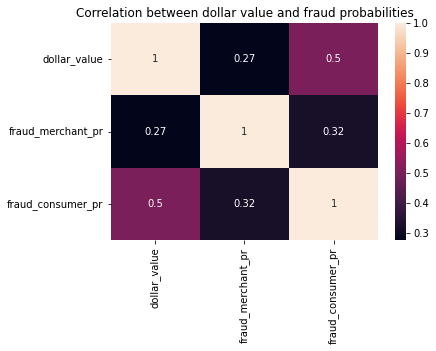

In [23]:
sns.heatmap(pd_fraud[["dollar_value", "fraud_merchant_pr", "fraud_consumer_pr"]].corr(), annot=True)
plt.title('Correlation between dollar value and fraud probabilities')
plt.show()

In [24]:
categories = pd_fraud["categories"].unique().tolist()

In [25]:
for category in categories:
    num_fraud = pd_fraud[pd_fraud["categories"] == category].shape[0]
    num_total = df_trx.where(F.col("categories") == category).count()
    print(f'Proportion of possible fraud in category {category} is {(num_fraud/num_total)*100}%')

Proportion of possible fraud in category florists supplies, nursery stock, and flowers is 0.34333305005523923%


Proportion of possible fraud in category stationery, office supplies and printing and writing paper is 0.8491261863688732%


Proportion of possible fraud in category computers, computer peripheral equipment, and software is 0.4090295275266374%


Proportion of possible fraud in category gift, card, novelty, and souvenir shops is 0.3373773142401417%


Proportion of possible fraud in category digital goods: books, movies, music is 0.30658409206674525%


Proportion of possible fraud in category equipment, tool, furniture, and appliance rent al and leasing is 10.44025978264417%


Proportion of possible fraud in category lawn and garden supply outlets, including nurseries is 1.0321996314688153%


Proportion of possible fraud in category furniture, home furnishings and equipment shops, and manufacturers, except appliances is 0.9473805677359797%


Proportion of possible fraud in category hobby, toy and game shops is 1.3157894736842104%


Proportion of possible fraud in category art dealers and galleries is 14.003624916531527%


Proportion of possible fraud in category motor vehicle supplies and new parts is 1.1972100760292246%


Proportion of possible fraud in category cable, satellite, and other pay television and radio services is 0.3685299017636583%


Proportion of possible fraud in category watch, clock, and jewelry repair shops is 0.3192219715832334%


Proportion of possible fraud in category artist supply and craft shops is 0.6498490508110322%


Proportion of possible fraud in category tent and awning shops is 0.7490738288442086%


Proportion of possible fraud in category shoe shops is 0.38796887524469575%


Proportion of possible fraud in category bicycle shops - sales and service is 1.2267575610476773%


Proportion of possible fraud in category music shops - musical instruments, pianos, and sheet music is 0.6402581647782685%


Proportion of possible fraud in category telecom is 13.279823733081523%


Proportion of possible fraud in category jewelry, watch, clock, and silverware shops is 38.0119366124717%


Proportion of possible fraud in category opticians, optical goods, and eyeglasses is 0.4744559593360654%


Proportion of possible fraud in category health and beauty spas is 0.5050713190008471%


Proportion of possible fraud in category computer programming , data processing, and integrated systems design services is 0.3836716679448439%


Proportion of possible fraud in category books, periodicals, and newspapers is 0.38716227261386155%


Proportion of possible fraud in category antique shops - sales, repairs, and restoration services is 1.2927934057816055%


In [11]:
all_trx = df_trx.join(fraud_data_merchant, on=["merchant_abn", "order_datetime"], how="left").withColumnRenamed("fraud_probability", "fraud_merchant_pr")
all_trx = all_trx.join(fraud_data_consumer, on=["user_id", "order_datetime"], how="left").withColumnRenamed("fraud_probability", "fraud_consumer_pr")
all_trx = all_trx.distinct()

In [13]:
dollar_trx_merchant = fraud_trx.groupby(["merchant_abn", "order_datetime", "fraud_merchant_pr"]).agg(F.sum(F.col("dollar_value")).alias("total_value"), \
    F.count("dollar_value").alias("num_transactions"), F.countDistinct("user_id").alias("unique_customers"))

In [23]:
dollar_pd_merchant = dollar_trx_merchant.toPandas()

In [41]:
dollar_pd_merchant = dollar_pd_merchant[dollar_pd_merchant["fraud_merchant_pr"].notnull()]

In [40]:
dollar_pd_merchant.sort_values("fraud_merchant_pr", ascending=False).head(10)

,merchant_abn,order_datetime,fraud_merchant_pr,total_value,num_transactions,unique_customers,average_trx_value
38530,35575706403,2022-02-20,91.096069,50209.505439,1,1,50209.505439
22981,97884414539,2021-10-19,89.799202,44615.022521,1,1,44615.022521
12702,14530561097,2021-09-15,80.800545,46001.139019,1,1,46001.139019
2518,18737319630,2021-09-25,72.730698,2228.722623,2,2,1114.361311
21745,85482742429,2021-11-27,70.881310,869.382020,6,6,144.897003
27917,78080443264,2021-11-26,69.095314,252.255627,5,5,50.451125
10136,83199298021,2021-03-25,69.085571,94120.008971,3,3,31373.336324
44153,76968105359,2021-12-09,68.278435,4221.751067,6,6,703.625178
45152,80089686333,2021-09-01,67.505814,1531.697541,4,4,382.924385
11543,79100970961,2022-01-02,67.117737,41689.730399,1,1,41689.730399


(0.0, 120000.0)

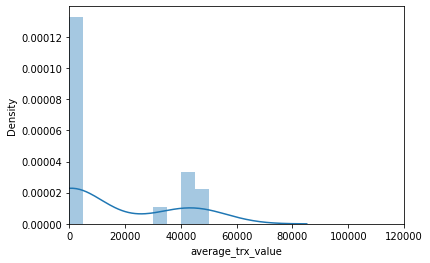

In [46]:
fig, ax = plt.subplots()
test_df = dollar_pd_merchant[dollar_pd_merchant['fraud_merchant_pr'] > 60]
sns.distplot(test_df["average_trx_value"], ax=ax, bins=10)
ax.set_xlim(0, 120000)

In [47]:
test_df

,merchant_abn,order_datetime,fraud_merchant_pr,total_value,num_transactions,unique_customers,average_trx_value
2518,18737319630,2021-09-25,72.730698,2228.722623,2,2,1114.361311
9914,93292821052,2021-11-29,66.587257,3297.655471,8,8,412.206934
10136,83199298021,2021-03-25,69.085571,94120.008971,3,3,31373.336324
11543,79100970961,2022-01-02,67.117737,41689.730399,1,1,41689.730399
12702,14530561097,2021-09-15,80.800545,46001.139019,1,1,46001.139019
13642,32258116290,2021-10-14,61.923809,1916.379603,4,4,479.094901
18911,86889657711,2021-09-05,63.212227,42835.547522,1,1,42835.547522
21745,85482742429,2021-11-27,70.881310,869.382020,6,6,144.897003
22981,97884414539,2021-10-19,89.799202,44615.022521,1,1,44615.022521
23452,30275989942,2022-01-28,63.108593,1558.875975,1,1,1558.875975


In [26]:
dollar_pd_merchant["average_trx_value"] = dollar_pd_merchant["total_value"] / dollar_pd_merchant["num_transactions"]

In [22]:
dollar_pd_merchant

,merchant_abn,order_datetime,fraud_merchant_pr,total_value,num_transactions,unique_customers,average_trx_value
0,82368304209,2021-08-31,NaN,28864.099950,7,7,4123.442850
1,98072939449,2021-10-04,NaN,2701.040934,1,1,2701.040934
2,38090089066,2021-12-24,NaN,542.985118,1,1,542.985118
3,93558142492,2021-12-27,NaN,593.519193,2,2,296.759597
4,76519958668,2021-12-07,NaN,125.987802,1,1,125.987802
...,...,...,...,...,...,...,...
46767,86010199872,2021-12-07,NaN,168.948143,1,1,168.948143
46768,16256895427,2021-12-12,NaN,345.943923,1,1,345.943923
46769,68264859271,2021-08-10,NaN,3517.116567,1,1,3517.116567
46770,30372130473,2021-12-25,NaN,414.607460,1,1,414.607460


<AxesSubplot:xlabel='total_value', ylabel='fraud_merchant_pr'>

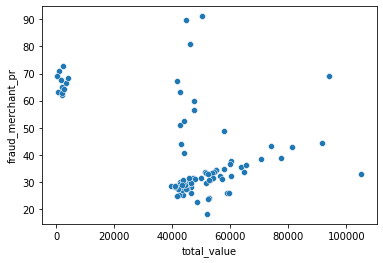

In [16]:
sns.scatterplot(dollar_pd_merchant["total_value"], dollar_pd_merchant["fraud_merchant_pr"])

<AxesSubplot:xlabel='average_trx_value', ylabel='fraud_merchant_pr'>

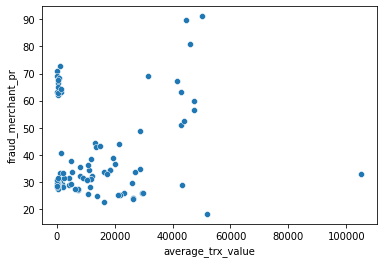

In [27]:
fig, ax = plt.subplots()
sns.scatterplot(dollar_pd_merchant["average_trx_value"], dollar_pd_merchant["fraud_merchant_pr"], ax=ax)

Current category: opticians, optical goods, and eyeglasses


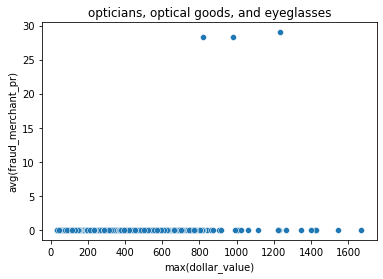

Current category: watch, clock, and jewelry repair shops


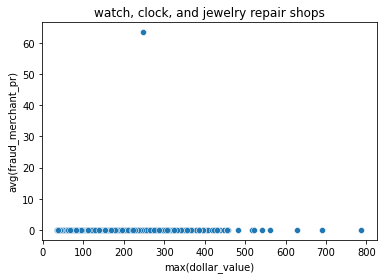

Current category: computer programming , data processing, and integrated systems design services


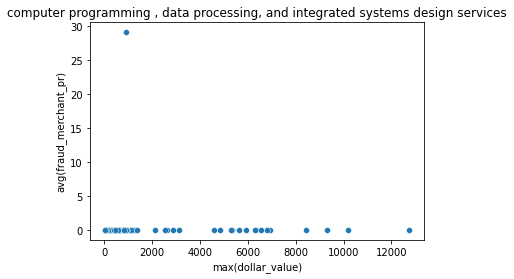

Current category: digital goods: books, movies, music


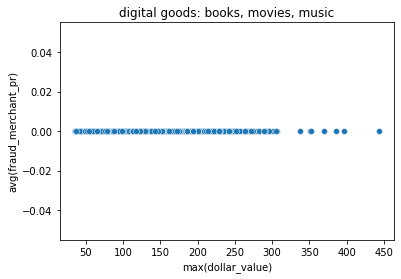

Current category: books, periodicals, and newspapers


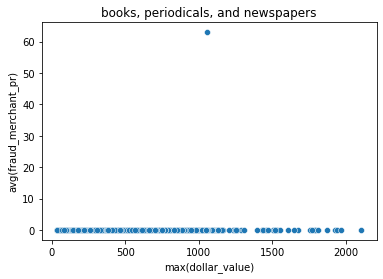

Current category: florists supplies, nursery stock, and flowers


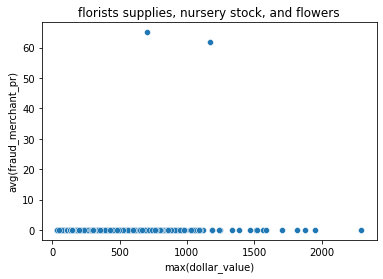

Current category: art dealers and galleries


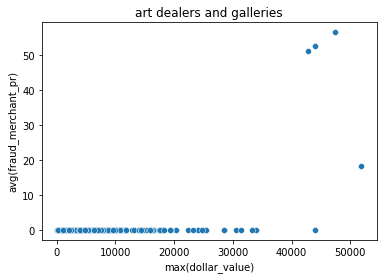

Current category: antique shops - sales, repairs, and restoration services


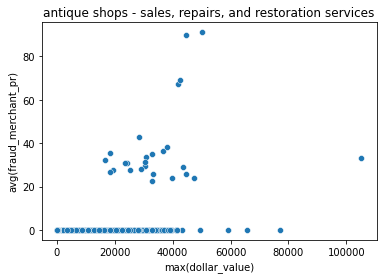

Current category: gift, card, novelty, and souvenir shops


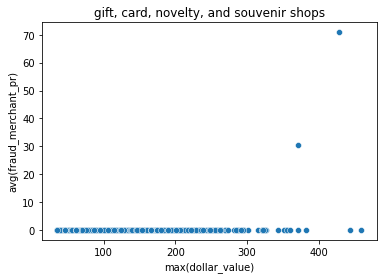

Current category: equipment, tool, furniture, and appliance rent al and leasing


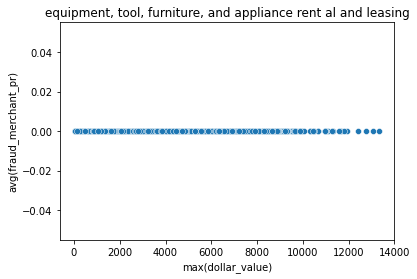

Current category: cable, satellite, and other pay television and radio services


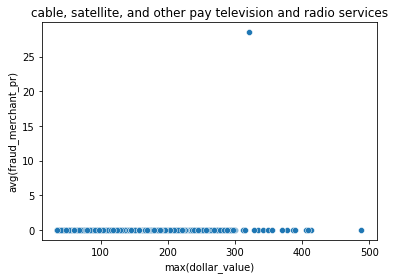

Current category: tent and awning shops


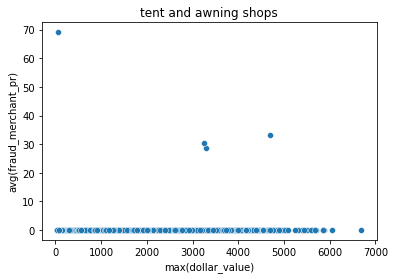

Current category: artist supply and craft shops


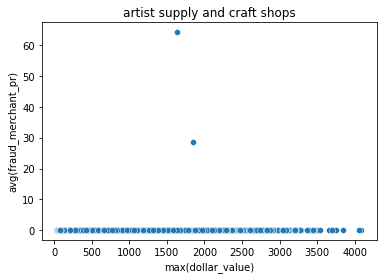

Current category: stationery, office supplies and printing and writing paper


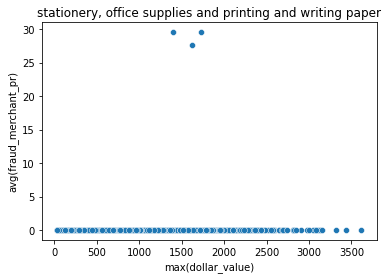

Current category: furniture, home furnishings and equipment shops, and manufacturers, except appliances


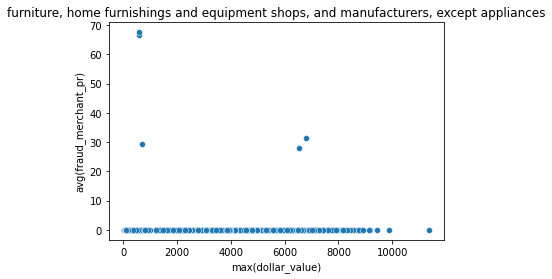

Current category: telecom


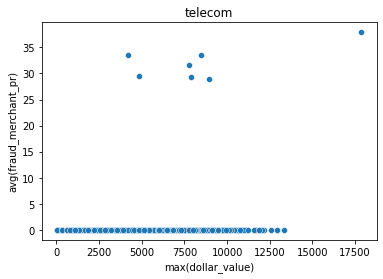

Current category: jewelry, watch, clock, and silverware shops


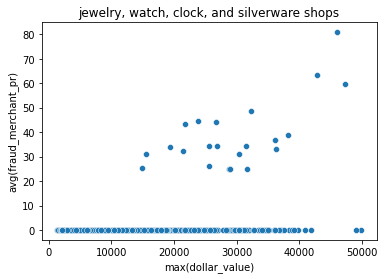

Current category: shoe shops


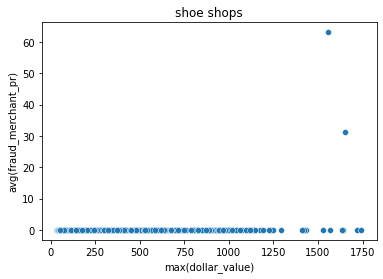

Current category: hobby, toy and game shops


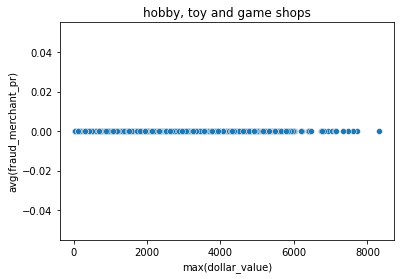

Current category: computers, computer peripheral equipment, and software


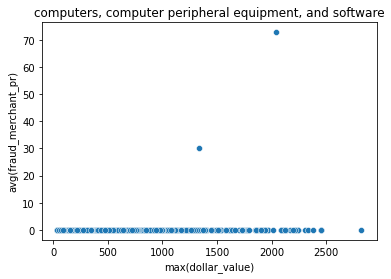

Current category: music shops - musical instruments, pianos, and sheet music


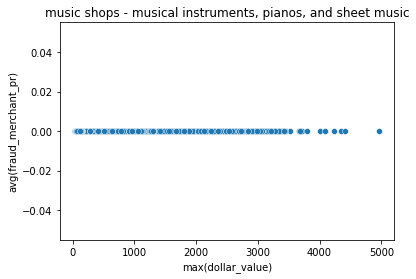

Current category: health and beauty spas


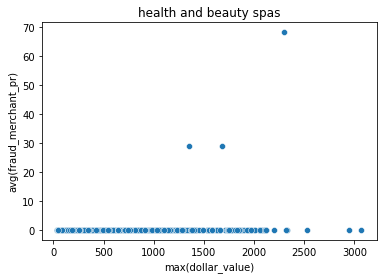

Current category: lawn and garden supply outlets, including nurseries


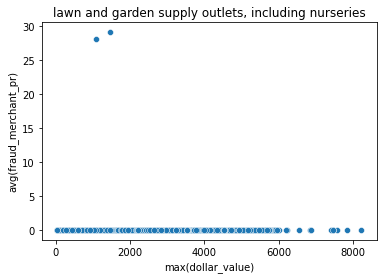

Current category: motor vehicle supplies and new parts


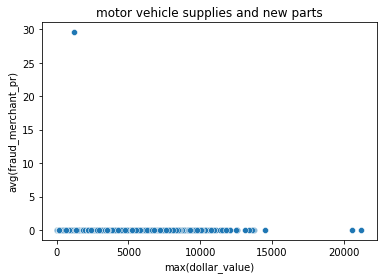

Current category: bicycle shops - sales and service


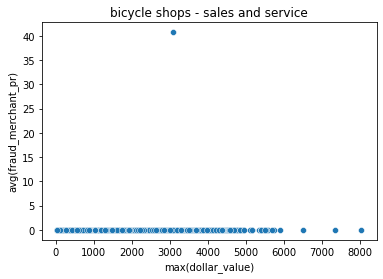

In [52]:
categories = all_trx.select("categories").distinct().collect()
for category in categories:
    category = category["categories"]
    category_trx = all_trx.where(F.col("categories") == category)
    category_trx = category_trx.groupby(["merchant_abn", "order_datetime"]).agg(F.mean(F.col("fraud_merchant_pr")), F.mean(F.col("fraud_consumer_pr")), \
    F.count(F.col("dollar_value")), F.sum(F.col("dollar_value")), F.min(F.col("dollar_value")))
    category_trx = category_trx.fillna(0)
    category_trx = category_trx.toPandas()
    print(f"Current category: {category}")
    sns.scatterplot(category_trx["max(dollar_value)"], category_trx["avg(fraud_merchant_pr)"])
    plt.title(category)
    plt.show()

In [32]:
all_consumer = all_trx.groupby(["user_id", "order_datetime", "fraud_consumer_pr"]).agg(F.countDistinct("merchant_abn").alias("unique_merchants"), \
    F.count("dollar_value").alias("num_transactions"), \
        F.sum("dollar_value").alias("total_amount"))

In [33]:
all_consumer = all_consumer.toPandas()

22/09/22 16:02:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/22 16:02:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/22 16:02:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/22 16:02:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/22 16:02:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/22 16:02:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/22 16:02:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/22 16:02:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/22 16:02:59 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/22 16:03:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/22 16:03:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/22 16:03:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/22 16:03:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/22 16:03:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/22 16:03:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/22 16:03:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/22 16:03:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/22 16:03:08 WARN RowBasedKeyValueBatch: Calling spill() on

In [34]:
all_consumer = all_consumer.fillna(0)

In [36]:
all_consumer.sort_values("num_transactions", ascending=False)

,user_id,order_datetime,fraud_consumer_pr,unique_merchants,num_transactions,total_amount
2876564,10904,2021-11-26,9.18446165409599,9,9,2980.159960
5286035,15483,2021-11-29,9.915624924913036,9,9,2660.788145
4855387,10326,2021-11-26,10.362651044336713,9,9,2207.282384
3230467,18374,2021-11-29,0,9,9,1246.989417
5780456,1652,2021-11-28,0,8,8,611.532803
...,...,...,...,...,...,...
2636059,18810,2021-08-28,0,1,1,467.740311
2636057,2085,2022-04-13,0,1,1,263.021414
2636056,13266,2022-06-13,0,1,1,121.133854
2636055,3255,2021-07-04,0,1,1,37.557025


In [86]:
all_consumer["fraud_consumer_pr"] = all_consumer["fraud_consumer_pr"].astype("float64")

In [91]:
all_consumer["transaction_merchant_ratio"] = all_consumer["unique_merchants"] / all_consumer["num_transactions"]

<AxesSubplot:>

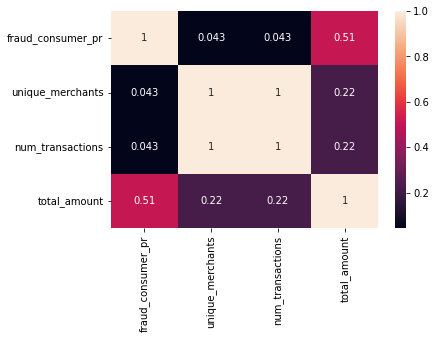

In [93]:
sns.heatmap(all_consumer[["fraud_consumer_pr", "unique_merchants", "num_transactions", "total_amount"]].corr(), annot=True)

In [67]:
fraud_data_merchant.groupby("merchant_abn").count().sort("count", ascending=False)

merchant_abn,count
31334588839,12
19492220327,8
90918180829,7
83199298021,6
93260930990,5
14827550074,4
27093785141,3
48534649627,3
90568944804,3
11149063370,3


In [115]:
fraud_data_merchant.where((F.col("merchant_abn") == "38700038932"))

merchant_abn,order_datetime,fraud_probability


In [116]:
fraud_trx.where(F.col("fraud_merchant_pr").isNotNull()).groupby(["merchant_abn", "order_datetime", "fraud_merchant_pr"]).agg(F.sum("dollar_value")).sort("sum(dollar_value)")

merchant_abn,order_datetime,fraud_merchant_pr,sum(dollar_value)
78080443264,2021-11-26,69.0953172336121,252.2556270555258
11470993597,2021-09-28,63.37734364737917,731.4499201211277
85482742429,2021-11-27,70.88131110541714,869.3820202563055
80089686333,2021-09-01,67.5058112247036,1531.6975405640226
30275989942,2022-01-28,63.108592876362856,1558.8759753180334
32258116290,2021-10-14,61.92380860960476,1916.379603198347
78187460332,2021-12-19,65.00576429421173,1952.8203207384136
22606727520,2021-11-27,62.992786990153064,1973.1560494458645
18737319630,2021-09-25,72.73069736562613,2228.722622568629
15157368385,2021-12-13,64.2774131928303,2661.792165827019


In [117]:
sus_merchant = all_trx.where((F.col("merchant_abn") == "78080443264") & (F.col("fraud_merchant_pr").isNotNull())).groupby("order_datetime").sum("dollar_value")

In [118]:
sus_merchant_pd = sus_merchant.toPandas()

In [119]:
sus_merchant_pd

,order_datetime,sum(dollar_value)
0,2021-11-26,252.255627


In [16]:
@F.udf(DoubleType())
def get_z(dollar, mean, sdev):
    if sdev == 0:
        z = 0
    elif sdev == None:
        z = -1
    else:
        z = (dollar - mean) / sdev
    return abs(z)

@F.udf(DoubleType())
def multiple(dollar, mean):
    return dollar / mean

@F.udf(BooleanType())
def has_fraud(fraud):
    if fraud == None:
        return False
    else:
        return True


In [53]:
df_mean_sd = all_trx.groupby("merchant_abn").agg(F.mean("dollar_value").alias("mean_trx"), F.stddev("dollar_value").alias("stddev_trx"))
df_grouped = all_trx.groupby(["merchant_abn", "order_datetime", "fraud_merchant_pr"]).agg(F.sum("dollar_value").alias("sum_trx"), \
    F.count("dollar_value").alias("count_trx"))
df_grouped = df_grouped.join(df_mean_sd, on="merchant_abn")
df_grouped = df_grouped.withColumn("z_score", get_z(F.col("sum_trx"), F.col("mean_trx"), F.col("stddev_trx")))
df_grouped = df_grouped.withColumn("multiple", multiple(F.col("sum_trx"), F.col("mean_trx")))
df_grouped = df_grouped.withColumn("has_fraud", has_fraud(F.col("fraud_merchant_pr")))

In [54]:
df_grouped = df_grouped.where(F.col("order_datetime") < "2022-02-28")

In [55]:
pd_grouped = df_grouped.where((F.col("fraud_merchant_pr").isNotNull())).toPandas()

22/09/29 15:55:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:55:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:55:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:55:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:55:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:55:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:55:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:55:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:55:37 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/29 15:55:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:55:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:55:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:55:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:55:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:55:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:55:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:55:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:55:46 WARN RowBasedKeyValueBatch: Calling spill() on

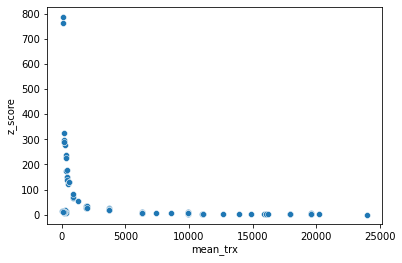

In [53]:
ax = sns.scatterplot(pd_grouped["mean_trx"], pd_grouped["z_score"])

In [71]:
pd_grouped_all = df_grouped.toPandas()

22/09/29 16:15:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 16:15:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 16:15:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 16:15:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 16:15:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 16:15:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 16:15:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 16:15:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/29 16:15:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 16:15:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 16:15:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 16:15:16 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/29 16:15:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 16:15:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 16:15:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 16:15:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 16:15:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 16:15:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 16:15:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 16:15:23 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


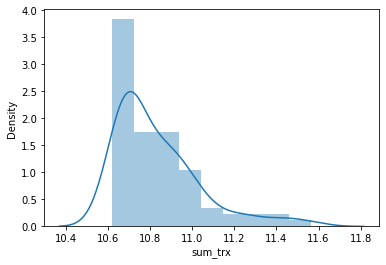

In [31]:
b = sns.distplot(np.log(pd_grouped[pd_grouped["sum_trx"] >= 40000]["sum_trx"]))

[(50.0, 2000.0)]

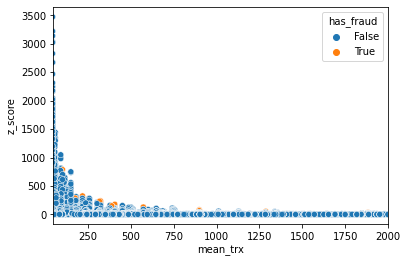

In [16]:
ax_z = sns.scatterplot(x = "mean_trx", y = "z_score", data=pd_grouped_all, hue="has_fraud")
ax_z.set(xlim=(50, 2000))

[(50.0, 2000.0)]

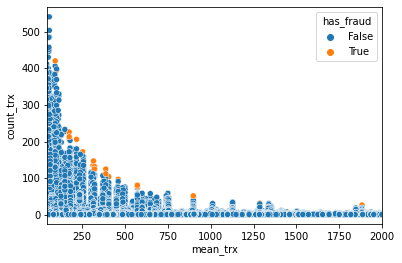

In [17]:
ax_count = sns.scatterplot(x="mean_trx", y="count_trx", data=pd_grouped_all, hue="has_fraud")
ax_count.set(xlim=(50, 2000))

[(0.0, 10.0)]

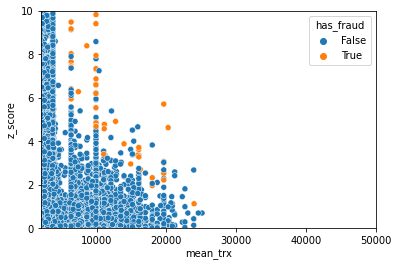

In [23]:
ax_z_high = sns.lmplot(x="mean_trx", y = "z_score", data=pd_grouped_all, hue="has_fraud")
ax_z_high.set(xlim=(2000, 50000))
ax_z_high.set(ylim=(0, 10))

In [108]:
pd_over_5k = pd_grouped[pd_grouped["mean_trx"] > 5000]

In [115]:
pd_over_5k

,merchant_abn,order_datetime,fraud_merchant_pr,sum_trx,count_trx,mean_trx,stddev_trx,z_score,multiple,has_fraud
6,19492220327,2021-10-18,30.935658544112286,57204.971471,5,9909.250618,6877.482432,6.876894,5.772886,True
7,19492220327,2022-01-29,25.071151926838045,42168.018943,2,9909.250618,6877.482432,4.690491,4.255420,True
8,19492220327,2021-10-08,25.50276371658429,43274.697887,4,9909.250618,6877.482432,4.851404,4.367101,True
9,19492220327,2021-11-28,44.403658647495355,91737.744885,7,9909.250618,6877.482432,11.898030,9.257788,True
10,19492220327,2021-11-03,24.872618445353506,41658.966991,3,9909.250618,6877.482432,4.616474,4.204048,True
11,19492220327,2021-12-18,33.819672154331755,64599.758207,4,9909.250618,6877.482432,7.952112,6.519137,True
12,19492220327,2021-12-22,38.867790051131095,77543.440280,4,9909.250618,6877.482432,9.834149,7.825359,True
13,19492220327,2021-11-18,32.193139919494016,60429.230386,5,9909.250618,6877.482432,7.345708,6.098264,True
15,97884414539,2021-10-19,89.79919971536573,44615.022521,1,11023.010101,9843.727337,3.412530,4.047445,True
16,83199298021,2021-12-14,22.799803337057128,48617.804064,3,19626.613727,13027.822507,2.225329,2.477137,True


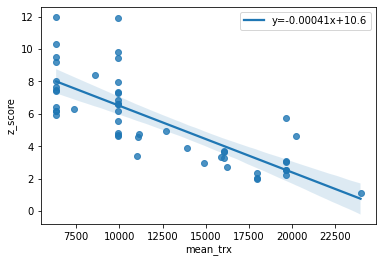

In [117]:
from scipy import stats
mask = ~np.isnan(pd_over_5k["mean_trx"]) & ~np.isnan(pd_over_5k["z_score"])
slope, intercept, r_value, p_value, std_err = stats.linregress(pd_over_5k["mean_trx"][mask], pd_over_5k["z_score"][mask])

ax = sns.regplot(x = pd_over_5k["mean_trx"], y = pd_over_5k['z_score'], line_kws={'label':"y={0:.5f}x+{1:.1f}".format(slope, intercept)})
ax.legend()
plt.show()

In [113]:
stats.linregress(pd_over_5k["mean_trx"], pd_over_5k["z_score"])

LinregressResult(slope=nan, intercept=nan, rvalue=nan, pvalue=nan, stderr=nan, intercept_stderr=nan)

In [24]:
fraud_data_merchant.agg({"order_datetime":"min", "order_datetime":"max"})

max(order_datetime)
2022-02-27


<AxesSubplot:>

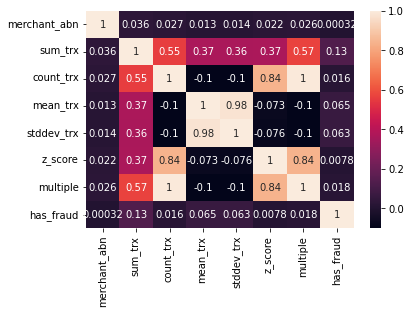

In [89]:
sns.heatmap(pd_grouped_all.corr(), annot=True)

Z-score plot (higher z-score values have a lot more fraud detected)

Transaction count may affect fraud probability more in lower transaction means (although transaction count and z-score may have strong correlation)

SVM for transactions under 5000

In [14]:
pd_svm = df_grouped.where(F.col("mean_trx") < 5000).toPandas()

22/09/29 15:27:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:37 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/29 15:27:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:38 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/29 15:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/29 15:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/29 15:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:43 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/29 15:27:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/29 15:27:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:52 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/29 15:27:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:27:55 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/29 15:28:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:28:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/29 15:28:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:28:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:28:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/29 15:28:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


In [15]:
pd_svm

,merchant_abn,order_datetime,fraud_merchant_pr,sum_trx,count_trx,mean_trx,stddev_trx,z_score,multiple,has_fraud
0,15613631617,2021-08-26,None,1337.188035,3,307.696188,195.866811,5.256081,4.345806,False
1,38700038932,2021-11-30,None,30982.747319,22,1338.867896,774.110454,38.294121,23.141004,False
2,73256306726,2021-12-01,None,5525.843425,18,300.108849,227.748591,22.945190,18.412797,False
3,38700038932,2021-07-14,None,16755.676462,12,1338.867896,774.110454,19.915515,12.514809,False
4,73256306726,2021-07-20,None,4214.483920,11,300.108849,227.748591,17.187264,14.043184,False
...,...,...,...,...,...,...,...,...,...,...
714690,38672941140,2021-11-16,None,2676.716832,1,1690.007661,1115.406327,0.884619,1.583849,False
714691,81249812970,2021-11-25,None,193.305788,1,486.978585,292.997209,-1.002306,0.396949,False
714692,86340649164,2021-06-14,None,2205.792510,1,1284.303508,758.628658,1.214677,1.717501,False
714693,11961681734,2021-04-21,None,473.080447,1,294.888194,227.209272,0.784265,1.604271,False


In [27]:
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [33]:
pd_transform = pd.DataFrame(scaler.transform(X), columns=["count", "mean"])
pd_transform["has_fraud"] = pd_svm["has_fraud"]

In [106]:
pd_reg = pd_grouped[(pd_grouped["count_trx"] < 20)]
pd_reg = pd_reg[pd_reg["mean_trx"] > 5000]
pd_reg["transform_mean"] = 1/np.sqrt(pd_reg["mean_trx"])

# pd_reg = pd_reg[(pd_reg["transform_mean"] > 0.03) & (pd_reg["transform_mean"] < 0.06)]

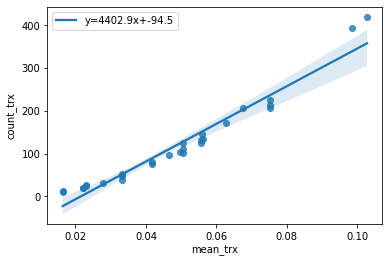

In [101]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(1/np.sqrt(pd_reg["mean_trx"]), pd_reg["count_trx"])

ax = sns.regplot(x = 1/np.sqrt(pd_reg["mean_trx"]), y = pd_reg['count_trx'], line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope, intercept)})
ax.legend()
plt.show()

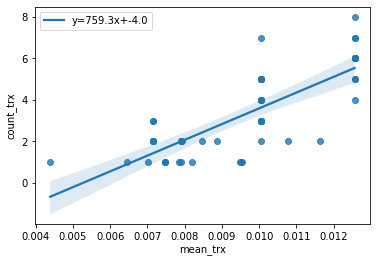

In [107]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(1/np.sqrt(pd_reg["mean_trx"]), pd_reg["count_trx"])

ax = sns.regplot(x = 1/np.sqrt(pd_reg["mean_trx"]), y = pd_reg['count_trx'], line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope, intercept)})
ax.legend()
plt.show()

In [105]:
pd_reg[(pd_reg['transform_mean']>0.04) & (pd_reg["transform_mean"] < 0.06)]

,merchant_abn,order_datetime,fraud_merchant_pr,sum_trx,count_trx,mean_trx,stddev_trx,z_score,multiple,has_fraud,transform_mean
3,27093785141,2021-11-27,29.539473036230746,46355.692237,112,389.688735,305.152044,150.633117,118.955690,True,0.050657
4,27093785141,2021-11-29,29.520113582407653,46312.932547,125,389.688735,305.152044,150.492991,118.845962,True,0.050657
5,27093785141,2021-11-26,27.58235777292768,42075.671047,102,389.688735,305.152044,136.607252,107.972511,True,0.050657
26,96680767841,2021-11-26,29.555244690425017,45873.671543,147,318.036454,197.904974,230.189439,144.240294,True,0.056074
29,39649557865,2021-11-26,28.690204286050616,44056.898577,97,461.796345,361.722290,120.520917,95.403307,True,0.046534
53,80518954462,2021-11-27,30.024291830924508,42644.158592,135,315.069291,243.721904,173.677821,135.348509,True,0.056337
54,50315283629,2021-11-26,29.088158119607012,44500.114501,125,323.860961,185.682636,237.912680,137.404997,True,0.055567
55,50315283629,2021-11-29,28.1008562280967,42372.964824,132,323.860961,185.682636,226.456845,130.836902,True,0.055567
56,18158387243,2021-11-26,29.102418916409913,43349.905137,81,573.560491,330.517008,129.422522,75.580354,True,0.041755
57,18158387243,2021-11-29,28.956947892226466,43041.943215,77,573.560491,330.517008,128.490764,75.043424,True,0.041755


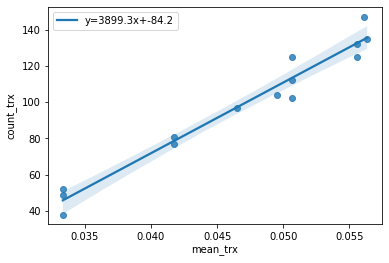

In [96]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(1/np.sqrt(pd_reg["mean_trx"]), pd_reg["count_trx"])

ax = sns.regplot(x = 1/np.sqrt(pd_reg["mean_trx"]), y = pd_reg[pd_reg["count_trx"]<300]['count_trx'], line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope, intercept)})
ax.legend()
plt.show()

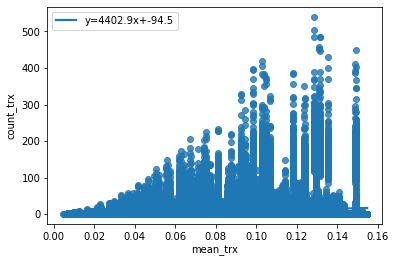

In [81]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(1/np.sqrt(pd_reg["mean_trx"]), pd_reg["count_trx"])
ax = sns.regplot(x = 1/np.sqrt(pd_reg["mean_trx"]), y = pd_reg["count_trx"], line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope, intercept)})
ax.legend()
plt.show()

In [88]:
std_err

203.19213087488473

In [84]:
pd_grouped_all["transform_mean"] = 1/np.sqrt(pd_grouped_all["mean_trx"])

In [86]:
pd_reg_all = pd_grouped_all[pd_grouped_all["count_trx"] > 10]

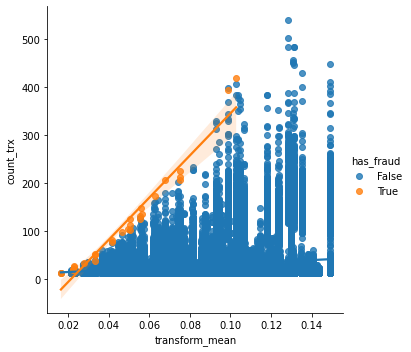

In [87]:
ax = sns.lmplot(x="transform_mean", y="count_trx", hue="has_fraud", data=pd_reg_all)


In [16]:
pd_svm = pd_svm[["count_trx", "mean_trx", "has_fraud"]]

In [17]:
from sklearn.svm import SVC
X = pd_svm[["count_trx", "mean_trx"]]
y = pd_svm["has_fraud"]

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipeline = make_pipeline(StandardScaler(), SVC())
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [25]:
y_train.value_counts()

False    571719
True         37
Name: has_fraud, dtype: int64

In [21]:
prediction = pipeline.predict(X_test)

<AxesSubplot:ylabel='has_fraud'>

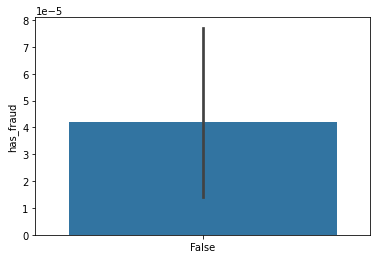

In [23]:
sns.barplot(prediction, y_test)

In [122]:
all_trx.groupby("merchant_abn").agg(F.mean("dollar_value"), F.stddev("dollar_value")).where(F.col("merchant_abn") == "78080443264")

merchant_abn,avg(dollar_value),stddev_samp(dollar_value)
78080443264,51.93360187517439,14.622631299261675


In [83]:
sus_merchant_pd = sus_merchant_pd.sort_values("order_datetime")

(array([0]), [Text(0, 0, '2021-12-18')])

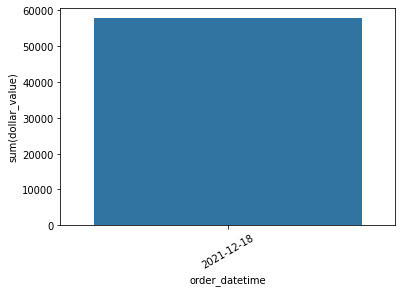

In [84]:
g = sns.barplot(sus_merchant_pd["order_datetime"], sus_merchant_pd["sum(dollar_value)"])
plt.xticks(rotation=30)

-----------------------------------------

In [84]:
fraud_data_consumer

user_id,order_datetime,fraud_probability
6228,2021-12-19,97.6298077657765
21419,2021-12-10,99.24738020302328
5606,2021-10-17,84.05825045251777
3101,2021-04-17,91.42192091901347
22239,2021-10-19,94.70342477508035
16556,2022-02-20,89.65663294494827
10278,2021-09-28,83.59136689427714
15790,2021-12-30,71.77065889280253
5233,2021-08-29,85.87123303878818
230,2021-08-28,86.28328808934151


In [85]:
df_trx.where((F.col("user_id") == "21419") & (F.col("order_datetime") == "2021-12-10"))

merchant_abn,user_id,consumer_id,consumer_name,address,state,postcode,gender,dollar_value,order_id,order_datetime,merchant_name,tags,categories,revenue_level,take_rate


In [66]:
fraud_data_consumer.groupby("user_id").count().sort("count", ascending=True)

user_id,count
21894,1
18992,1
17427,1
17401,1
4937,1
18574,1
296,1
19095,1
14369,1
18947,1


In [74]:
all_trx.where((F.col("user_id") == "21419") & (F.col("fraud_consumer_pr").isNotNull()))

user_id,order_datetime,merchant_abn,consumer_id,consumer_name,address,state,postcode,gender,dollar_value,order_id,merchant_name,tags,categories,revenue_level,take_rate,fraud_merchant_pr,fraud_consumer_pr


In [120]:
sus_consumer = all_trx.where((F.col("fraud_consumer_pr").isNotNull())).groupby(["user_id", "order_datetime"]).sum("dollar_value")

In [121]:
sus_consumer_pd = sus_consumer.toPandas()

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [122]:
sus_consumer_pd

,user_id,order_datetime,sum(dollar_value)
0,21403,2021-12-14,3305.311352
1,7436,2021-11-29,1817.722342
2,9444,2021-05-16,8453.969785
3,2724,2021-12-25,2648.604832
4,6891,2021-04-19,4175.394814
...,...,...,...
31764,7644,2021-10-12,4111.787313
31765,11761,2021-08-29,2342.500720
31766,19821,2021-11-18,3430.251282
31767,628,2021-10-08,4831.261426


<AxesSubplot:xlabel='sum(dollar_value)', ylabel='Density'>

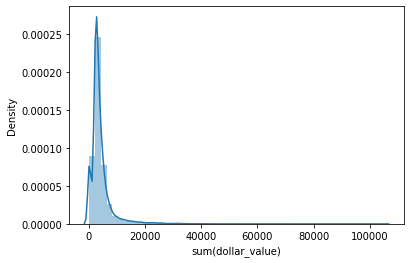

In [124]:
sns.distplot(sus_consumer_pd["sum(dollar_value)"])

In [83]:
all_trx.groupby(["user_id", "order_datetime"]).sum("dollar_value").where((F.col("user_id") == "21419")).sort("sum(dollar_value)").show(500, truncate=False)

+-------+--------------+------------------+
|user_id|order_datetime|sum(dollar_value) |
+-------+--------------+------------------+
|21419  |2022-09-29    |35.37764463402923 |
|21419  |2021-12-28    |35.48322669808732 |
|21419  |2021-05-25    |35.867713352692675|
|21419  |2022-05-08    |35.93902206293581 |
|21419  |2021-07-24    |36.24792480008263 |
|21419  |2022-04-02    |36.42635252676885 |
|21419  |2021-12-29    |36.76722209466965 |
|21419  |2022-08-12    |37.48419093679651 |
|21419  |2021-07-29    |37.69223314340784 |
|21419  |2022-05-19    |38.319854948171866|
|21419  |2022-02-08    |38.36751034123534 |
|21419  |2022-03-23    |39.658856229141755|
|21419  |2021-04-14    |39.72404340312182 |
|21419  |2022-08-07    |40.74693660960774 |
|21419  |2022-01-10    |41.393165155738   |
|21419  |2021-04-29    |41.55098153864167 |
|21419  |2021-04-23    |42.30076850764152 |
|21419  |2021-03-01    |42.30835851081112 |
|21419  |2022-09-27    |43.21223163518783 |
|21419  |2022-04-19    |44.28973

In [35]:
df_mean_sd_consumer = all_trx.groupby("user_id").agg(F.mean("dollar_value").alias("mean_trx"), \
    F.stddev("dollar_value").alias("stddev_trx"))
df_daily_consumer = all_trx.groupby(["user_id", "order_datetime", "fraud_consumer_pr"]).agg(F.sum("dollar_value").alias("sum_trx"), \
    F.count("dollar_value").alias("count_trx"))
df_daily_consumer = df_daily_consumer.join(df_mean_sd_consumer, on="user_id")
df_daily_consumer = df_daily_consumer.where(F.col("order_datetime") < "2022-02-28")
df_daily_consumer = df_daily_consumer.withColumn("z_score", get_z(F.col("sum_trx"), F.col("mean_trx"), F.col("stddev_trx")))
df_daily_consumer = df_daily_consumer.withColumn("has_fraud", has_fraud(F.col("fraud_consumer_pr")))

In [30]:
pd_daily_consumer = df_daily_consumer.toPandas()

22/10/01 04:12:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:12:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:12:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:12:41 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 04:12:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:12:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 04:12:48 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 04:12:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:12:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:12:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:12:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 04:12:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:12:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 04:12:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:12:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:12:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:12:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:12:53 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 04:12:54 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 04:13:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 04:13:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:13:02 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:13:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:13:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:13:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:13:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:13:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:13:03 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:13:03 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/01 04:13:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:13:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 04:13:05 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


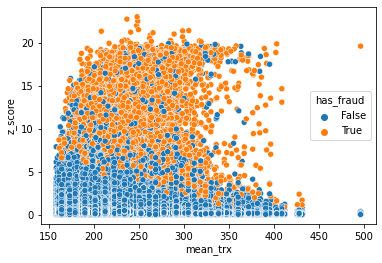

In [31]:
ax_consumer = sns.scatterplot(x="mean_trx", y = "z_score", data=pd_daily_consumer, hue="has_fraud")

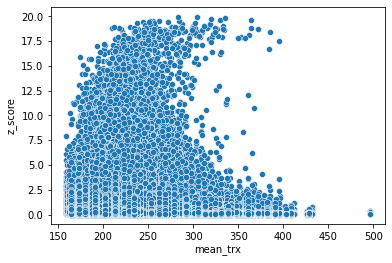

In [28]:
ax_consumer_false = sns.scatterplot(x="mean_trx", y="z_score", data=pd_daily_consumer[pd_daily_consumer["has_fraud"] == False])

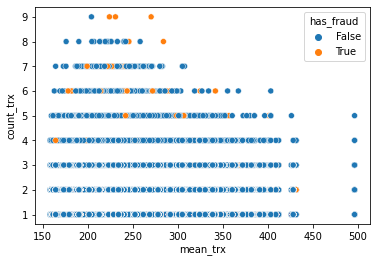

In [33]:
ax_consumer_count = sns.scatterplot(x="mean_trx", y="count_trx", data=pd_daily_consumer, hue="has_fraud")

In [36]:
first_day_trx = all_trx.groupby("user_id").agg(F.min("order_datetime").alias("first_date"))

In [37]:
df_daily_consumer = df_daily_consumer.join(first_day_trx, on="user_id")
df_daily_consumer = df_daily_consumer.withColumn("first_time", (F.col("order_datetime") == F.col("first_date")))

In [38]:
pd_daily_consumer = df_daily_consumer.toPandas()

22/10/01 08:24:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 08:24:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 08:24:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:32 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 08:24:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 08:24:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:33 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/01 08:24:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 08:24:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


In [53]:
pd_daily_consumer[pd_daily_consumer["has_fraud"]==True]

,user_id,order_datetime,fraud_consumer_pr,sum_trx,count_trx,mean_trx,stddev_trx,z_score,has_fraud,first_date,first_time
247,19,2021-11-27,14.310022438431579,2934.675453,2,219.628910,386.286636,7.028580,True,2021-02-28,False
430,22,2021-11-03,10.569931346938821,2272.177699,1,205.249788,387.281739,5.337014,True,2021-02-28,False
553,26,2021-11-19,10.604536233608997,2598.982070,2,214.581403,384.505562,6.201212,True,2021-02-28,False
780,29,2021-10-31,8.443970107947875,2569.639759,1,244.367130,423.067618,5.496220,True,2021-02-28,False
805,29,2021-11-25,15.492409971599415,4709.219143,2,244.367130,423.067618,10.553519,True,2021-02-28,False
...,...,...,...,...,...,...,...,...,...,...,...
3896992,24006,2021-09-12,14.19144266239539,3547.286130,1,206.409351,336.401979,9.931204,True,2021-03-02,False
3897033,24006,2021-10-21,13.912951942703376,3484.160445,1,206.409351,336.401979,9.743555,True,2021-03-02,False
3897046,24006,2021-09-26,8.311021859023393,2081.293297,1,206.409351,336.401979,5.573344,True,2021-03-02,False
3897217,24024,2022-01-15,12.860804437265468,3278.450869,1,234.344891,411.138031,7.404097,True,2021-03-09,False


<AxesSubplot:xlabel='has_fraud', ylabel='sum_trx'>

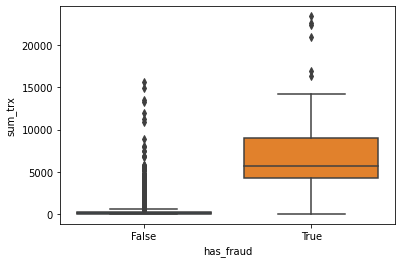

In [55]:
sns.boxplot(x="has_fraud", y="sum_trx", data=pd_daily_consumer[pd_daily_consumer["first_time"] == True])

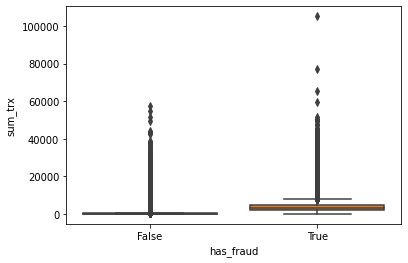

In [49]:
a = sns.boxplot(x="has_fraud", y="sum_trx", data=pd_daily_consumer[pd_daily_consumer["first_time"] == False])

In [56]:
df_daily_consumer = df_daily_consumer.sort(["user_id", "order_datetime"], ascending=True)

In [59]:
win = Window.partitionBy("user_id").orderBy("order_datetime")
df_daily_consumer = df_daily_consumer.withColumn("prev_order_date", F.lag(df_daily_consumer["order_datetime"]).over(win))
df_daily_consumer = df_daily_consumer.withColumn("trx_gap", F.datediff(F.col("order_datetime"), F.col("prev_order_date")))

In [60]:
df_daily_consumer

22/10/01 11:10:13 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 11:10:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 11:10:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:14 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/01 11:10:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:15 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/01 11:10:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:24 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:24 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/01 11:10:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:10:26 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/01 11:13:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:17 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:17 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/01 11:13:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:26 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:26 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/01 11:13:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 11:13:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:13:36 WARN RowBasedKeyValueBatch: Calling spill() on

user_id,order_datetime,fraud_consumer_pr,sum_trx,count_trx,mean_trx,stddev_trx,z_score,has_fraud,first_date,first_time,prev_order_date,trx_gap
7,2021-02-28,null,89.93535555889761,1,222.6766662012227,350.8095089816762,0.3783857257109258,false,2021-02-28,true,null,null
7,2021-03-07,null,147.1461539356358,1,222.6766662012227,350.8095089816762,0.21530349187180126,false,2021-02-28,false,2021-02-28,7
7,2021-03-12,null,179.95765381097175,1,222.6766662012227,350.8095089816762,0.12177267518846616,false,2021-02-28,false,2021-03-07,5
7,2021-03-19,null,292.57561334822606,2,222.6766662012227,350.8095089816762,0.19925043465869788,false,2021-02-28,false,2021-03-12,7
7,2021-03-24,null,1477.9174337803072,1,222.6766662012227,350.8095089816762,3.5781264060451954,false,2021-02-28,false,2021-03-19,5
7,2021-03-27,null,62.10343310638136,1,222.6766662012227,350.8095089816762,0.45772200862214524,false,2021-02-28,false,2021-03-24,3
7,2021-03-29,null,535.576742205508,2,222.6766662012227,350.8095089816762,0.8919372707785667,false,2021-02-28,false,2021-03-27,2
7,2021-04-01,null,171.86087818023483,1,222.6766662012227,350.8095089816762,0.14485293790494752,false,2021-02-28,false,2021-03-29,3
7,2021-04-02,null,143.21530076247532,1,222.6766662012227,350.8095089816762,0.22650858487105002,false,2021-02-28,false,2021-04-01,1
7,2021-04-07,null,75.4571735676935,1,222.6766662012227,350.8095089816762,0.4196565054946071,false,2021-02-28,false,2021-04-02,5


In [61]:
pd_daily_consumer = df_daily_consumer.toPandas()

22/10/01 11:18:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:06 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 11:18:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 11:18:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 11:18:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:12 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 11:18:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:21 WARN RowBasedKeyValueBatch: Calling spill() on

22/10/01 11:18:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/10/01 11:18:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:31 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/01 11:18:31 WARN RowBasedKeyValueBatch: Calling spill() on

<AxesSubplot:xlabel='trx_gap', ylabel='count_trx'>

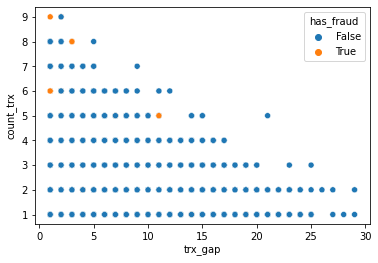

In [67]:
sns.scatterplot(x="trx_gap", y="count_trx", data=pd_daily_consumer, hue="has_fraud")

In [73]:
pd_daily_consumer[pd_daily_consumer["z_score"] > 15].count()

user_id              2699
order_datetime       2699
fraud_consumer_pr    2252
sum_trx              2699
count_trx            2699
mean_trx             2699
stddev_trx           2699
z_score              2699
has_fraud            2699
first_date           2699
first_time           2699
prev_order_date      2677
trx_gap              2677
dtype: int64

In [74]:
pd_daily_consumer[(pd_daily_consumer["z_score"] > 15) & (pd_daily_consumer["has_fraud"] == True)].count()

user_id              2252
order_datetime       2252
fraud_consumer_pr    2252
sum_trx              2252
count_trx            2252
mean_trx             2252
stddev_trx           2252
z_score              2252
has_fraud            2252
first_date           2252
first_time           2252
prev_order_date      2239
trx_gap              2239
dtype: int64

In [78]:
all_trx.withColumn("month", F.month(F.col("order_datetime"))).groupby(["user_id", "month"]).sum("dollar_value").count()

288972